# Dogs vs. Cats
- https://www.kaggle.com/c/dogs-vs-cats/data

Source code: https://github.com/deeplizard/Keras_Jupyter_Notebooks

In [1]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

/Users/kth/miniconda3/envs/ml/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# set directories
train_path = 'dogs_and_cat/train'
valid_path = 'dogs_and_cat/val'
test_path = 'dogs_and_cat/test'

In [3]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=['dog', 'cat'], batch_size=20)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224), classes=['dog', 'cat'], batch_size=10)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), classes=['dog', 'cat'], batch_size=10)

Found 80 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [4]:
# Plot images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [7]:
# Get the first train batch
imgs, labels = next(train_batches)

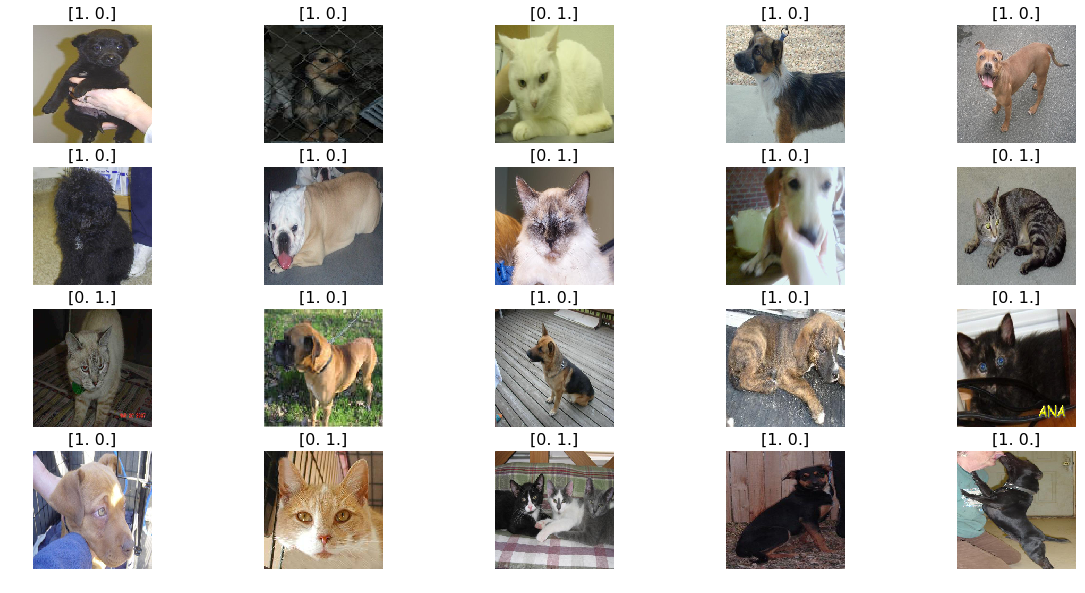

In [8]:
# Plot images in the first train batch
plots(imgs, figsize=(20,10), rows=4, titles=labels)

# Train a simple CNN

In [9]:
simple_model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,3)),
        Flatten(),
        Dense(2, activation='softmax'),
    ])

In [10]:
simple_model.compile(Adam(lr=.0005), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
simple_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
flatten_1 (Flatten)          (None, 1577088)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 3154178   
Total params: 3,155,074
Trainable params: 3,155,074
Non-trainable params: 0
_________________________________________________________________


In [12]:
simple_model.fit_generator(train_batches, 
#                          steps_per_epoch=4, 
                           validation_data=valid_batches, 
                           validation_steps=4, 
                           epochs=10, 
                           verbose=1)

Epoch 1/10
4/4 [==============================] - 2s 502ms/step - loss: 8.1594 - acc: 0.4750 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/10
4/4 [==============================] - 2s 432ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/10
4/4 [==============================] - 2s 409ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/10
4/4 [==============================] - 2s 400ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 5/10
4/4 [==============================] - 2s 430ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 6/10
4/4 [==============================] - 2s 421ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 7/10
4/4 [==============================] - 2s 433ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 8/10
4/4 [==============================] - 2s 419ms/step - loss: 8.0590 - acc: 0.50

# Predict test data with trained simple CNN

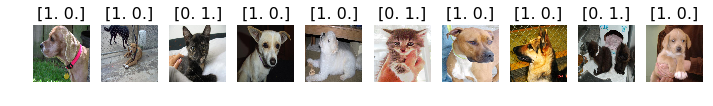

In [13]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [14]:
test_labels = test_labels[:,0]
test_labels

array([1., 1., 0., 1., 1., 0., 1., 1., 0., 1.], dtype=float32)

In [15]:
predictions = simple_model.predict_generator(test_batches, steps=1, verbose=0)

In [16]:
predictions

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [17]:
cm = confusion_matrix(test_labels, predictions[:,0])

In [18]:
print(cm)

[[3 0]
 [7 0]]


# Fine-tune the pretrained VGG16

In [19]:
# !pip install h5py

In [20]:
vgg16_model = keras.applications.vgg16.VGG16()

In [19]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [21]:
new_model = Sequential()
for layer in vgg16_model.layers:
    new_model.add(layer)

In [22]:
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [23]:
# Eliminate 'predictions' layer
new_model.layers.pop()

In [24]:
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [25]:
# Make all layers untrainable
for layer in new_model.layers:
    layer.trainable = False

In [26]:
# Add softmax layer
new_model.add(Dense(2, activation='softmax'))

In [27]:
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [28]:
new_model.compile(Adam(lr=.0005), loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
new_model.fit_generator(train_batches, 
#                       steps_per_epoch=4, 
                        validation_data=valid_batches, 
                        validation_steps=4,
                        epochs=10, 
                        verbose=1)

Epoch 1/10
4/4 [==============================] - 34s 8s/step - loss: 0.6787 - acc: 0.7875 - val_loss: 0.6712 - val_acc: 0.9000
Epoch 2/10


KeyboardInterrupt: 

# Predict using fine-tuned VGG16 model

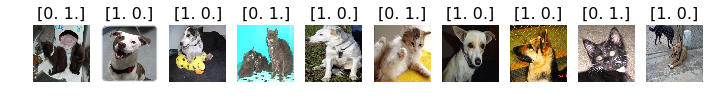

In [35]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [36]:
test_labels = test_labels[:,0]
test_labels

array([0., 1., 1., 0., 1., 0., 1., 1., 0., 1.], dtype=float32)

In [38]:
predictions = new_model.predict_generator(test_batches, steps=1, verbose=0)
predictions

array([[0.46103644, 0.5389635 ],
       [0.52305055, 0.47694945],
       [0.461448  , 0.5385519 ],
       [0.51953274, 0.48046735],
       [0.46102944, 0.5389705 ],
       [0.52457595, 0.47542402],
       [0.523946  , 0.476054  ],
       [0.46133217, 0.53866786],
       [0.46195728, 0.53804266],
       [0.46138507, 0.53861487]], dtype=float32)

In [39]:
new_cm = confusion_matrix(test_labels, np.round(predictions[:,0]))

In [40]:
new_cm

array([[2, 2],
       [4, 2]])